# Single-Output Regression Neural Network pada kasus Prediksi Kualitas Air

Notebook ini hanya __contoh__ dan dibuat untuk __pembelajaran__ mengenai _Deep Learning/Neural Networks_ dan penggunaan praktis bidang sumberdaya air menggunakan _Python_. Notebook ini masih perlu dievaluasi kembali jika digunakan untuk kepenting riset/penelitian ataupun proyek. Jika memiliki komentar, saran, kritik, ataupun pertanyaan, dapat menghubungi saya di hi@taruma.info (atau langsung melalui Google Colab).

Berhubung proses `fit` data _training_ sudah pernah dilakukan, dalam _notebook_ ini hanya memuat (_loading_) dari hasil _training_ sebelumnya.

# Deskripsi Kasus

Bagian ini akan menjelaskan gambaran umum mengenai dataset, permasalahan/tujuan, dan langkah penyelesaiannya


## Dataset

Dataset merupakan data kualitas air __bulanan__ dari __Juni 2000 hingga Desember 2017__ (211 data bulanan). Dataset memiliki 15 kolom yaitu (berurutan):
- __1 kolom berupa tanggal__
- __11 kolom _independent variables_ yang diperoleh di stasiun A__:
    - temperatur udara (`temp_udara`), lama penyinaran (`lama_sinar`), kecepatan angin (`kec_angin`), $Q_{in}$ (`debit_masuk`), $Q_{out}$ (`debit_keluar`), volume (`volume`), temperatur air (`temp_air`), $O_2$, Oksigen (`oksigen`), $NO_2$, Nitrogen (`nitrogen`), $NO_3$, Nitrat (`nitrat`), $NH_3$, Amonia (`amonia`).
- __3 kolom _dependent variables_ pada stasiun B__:
    - $NO_2$, Nitrogen (`out_nitrogen`), $NO_3$, Nitrat (`out_nitrat`), $NH_3$, Amonia (`out_amonia`).

## Permasalahan dan Tujuan

__Permasalahan__: 
- Peneliti ingin mengetahui nilai tiga kualitas air berupa $NO_2, NO_3, NH_3$ pada stasiun B berdasarkan informasi yang diperoleh di stasiun A. 

__Batasan Masalah__: 
- Dalam _notebook_ ini _target_ yang digunakan hanya $NH_3$ (_single-output_). 
- Arsitektur _Neural Networks_ yang digunakan adalah _Multi Layer Perceptron_ (MLP), dengan setidaknya _hidden layers_ lebih dari satu.
- Kasus disini merupakan contoh permasalahan _supervised learning_.

__Pertanyaan__: 
- Berapa nilai NH3 pada stasiun B pada waktu $t$ jika __telah diketahui__ hasil pengukuran di stasiun A pada waktu $t$ __dan__ hasil observasi stasiun B pada waktu sebelumnya ($t-1, t-2, ..., t-n$, dengan $n$ adalah jumlah _timesteps_)?
- Apa arsitektur _NN_ yang optimal untuk melakukan prediksi kualitas air?

_Catatan_: Dalam kasus ini akan digunakan _$2$ timesteps_ yang berarti data __dua bulan yang lalu__ akan digunakan sebagai _input_ untuk memprediksikan _target_ pada waktu $t$.


## Strategi Penyelesaian Masalah

### Tahap 1: _Data exploration and Data munging_
1. _Import_ dataset dari berkas excel ke dalam `pandas.DataFrame`.
2. Eksplorasi dataset berupa memeriksa kehilangan data disertai validasi dan verifikasi data. _Data exploration_ dapat berupa visualisasi, deskripsi statistik, dan memeriksa jika terdapat nilai _outlier_ atau tidak.
3. Jika terdapat data yang hilang, maka __diasumsikan__ data memiliki sifat _linear_ sehingga data yang hilang diisi dengan menginterpolasikan dengan metode linear. (Langkah ini dapat diganti dengan kesesuaian keahlian bidangnya)
4. Diperiksa kembali data yang telah diisi dan melakukan ekplorasi data lagi untuk memastikan dataset sudah siap untuk diolah di tahap berikutnya.

### Tahap 2: _Data Preprocessing_
1. Membagi dataset menjadi dua bagian yaitu __training set dan test set__. Pemotongan data ini tidak acak. __Training set__ merupakan potongan data dari __Juni 2000 hingga Desember 2014__. __Test set__ merupakan potongan data dari __Januari 2015 hingga Desember 2017__. Untuk selanjutnya hanya __training set__ yang akan diproses untuk training dan __test set__ disimpan untuk tahap evaluasi model. 
2. Dilakukan tahap ___Scaling___ yaitu menormalisasikan nilai pada dataset ke dalam skala yang sama. Digunakan metode `MinMaxScaler` karena diketahui data tidak terdistribusi normal. 
3. Membuat kolom yang menunjukkan _$2$ timesteps_, sehingga dataset yang sebelumnya 14 kolom menjadi $feature_{original}\times(timesteps+1)=14\times(2+1)=42$. 
4. Menampilkan hasil penambahan _timesteps_ dalam bentuk `pandas.DataFrame`.
5. __training set__ dibagi menjadi `X_train` dan `y_train`. Dengan `X_train` merupakan seluruh kolom __kecuali__ nilai observasi dari stasiun B pada waktu $t$ (kolom: `out_nitrogen_tmin0, out_nitrat_tmin0, out_amonia_tmin0`) sebagai _feature_. Sedangkan `y_train` merupakan kolom `out_amonia_tmin0` sebagai _target_. 

### Tahap 3: _Building Neural Networks_
1. Untuk Neural Networks digunakan _Multi Layer Perceptron (MLP)_ dengan target _single-output_.
2. Membuat fungsi `build_model` yang memberikan fleksibilitas arsitektur sehingga memiliki hidden layer lebih dari satu dengan parameter `hidden_layers`.
3. Menggunakan `GridSearchCV` untuk mengetahui parameter terbaik. Kombinasi parameter yang dicoba adalah (dengan `cv=3`):
```python
param_grid = dict(epochs=[100,150,200],
                  batch_size=[5,10,20],
                  first_layer=[10, 20, 30],
                  hidden_layers=[[10], [20], [30]],
                  activation=['sigmoid', 'relu'],
                  optimizer=['adam'],
                 )
 ```
4. Melalukan proses `fit` terhadap `X_train, y_train`. Besarnya _validation split_ yang digunakan sebesar $0.2$.
 
### Tahap 4: _Evaluation Models_
1. Pada tahap evaluasi, dataset yang digunakan adalah __test set__. _test set_ yang diperoleh dari pembagian set perlu diproses lebih lanjut sebelum digunakan untuk memprediksi.
2. Dilakukan proses _data preprocessing_ seperti tahap 2 langkah 2-5 pada __test set__.
3. Memprediksi nilai dengan model yang terbaik hasil _Grid Search_. 
4. Mengembalikan nilai prediksi dan nilai `y_test` ke skala original dengan menggunakan _method_ `inverse_transform`. Hal ini dilakukan dengan mentransfer atribut `MinMaxScaler` sebelumnya ke _object_ baru, agar menyederhanakan proses pengembalian ke skala asli.
5. Evaluasi menggunakan metrik RMSE/MAE.
6. Evaluasi menggunakan grafik.
7. Menghitung nilai beda prediksi dan observasi, dan dilakukan statistik deskriptif disertai membuat histogram nilai residu tersebut.

### Tahap 5: _Conclusion and Interpretation_
1. Tahap ini menyimpulkan hasil model dan menginterpretasikan model NN.
2. Langkah yang bisa meningkatkan hasil model dengan mengurangi kemungkinan _overfitting_ ataupun _underfitting_.


# Tahap 0: Pengaturan Awal

Bagian ini merupakan pengaturan awal pribadi, dapat diabaikan.

In [0]:
#@title PROJECT DESCRIPTION
from datetime import datetime

#### PROJECT DESCRIPTION
notebook_title = 'kualitas_air_ann_so' #@param {type:"string"}
prefix = datetime.utcnow().strftime("%Y%m%d_%H%M")
project_title = prefix + '_' + notebook_title

print(f'Judul Notebook: {notebook_title}')
print(f'Judul Proyek: {project_title}')

Judul Notebook: kualitas_air_ann_so
Judul Proyek: 20190514_1517_kualitas_air_ann_so


In [0]:
#### Memasang Akses Google Drive (untuk tempat menyimpan hasil training)
from google.colab import drive
drive.mount('/content/gdrive')
drop_path = '/content/gdrive/My Drive/Colab Notebooks/_dropbox'

In [0]:
#### Instalasi Paket Python Pribadi (untuk Logging)
#### https://github.com/taruma/umakit
!pip install umakit
from umakit.logtool import LogTool
mylog = LogTool()
mylog._reset()

#### Instalasi Paket Hidrokit (untuk plotting, dan transformasi kolom saat data preprocessing)
#### https://github.com/taruma/hidrokit
!pip install hidrokit
from hidrokit.dlkit import plot_dataset, single_column_timesteps, multi_column_timesteps

In [0]:
#### Import fungsi kirim email pribadi
import importlib.util
spec = importlib.util.spec_from_file_location("module.name", "/content/gdrive/My Drive/Colab Notebooks/uma_send.py")
uma = importlib.util.module_from_spec(spec)
spec.loader.exec_module(uma)

# Tahap 1: _Data Exploration and Data Munging_

Ringkasan pada tahap ini:

1. _Import_ dataset.
2. Eksplorasi dataset.
3. Mengisi data yang hilang.
4. Eksplorasi dataset kembali.

## 1.1 Import dataset

In [0]:
#### Mengunggah dataset
from google.colab import files
uploaded = files.upload()

Saving data_ka.xlsx to data_ka.xlsx


In [0]:
#### 1. Import dataset ke pandas.DataFrame
import pandas as pd

## import dataset
dataset = pd.read_excel('data_ka.xlsx', skiprows=[0])

## Menamai kolom
dataset.columns = ["date", "temp_udara", "lama_sinar", "kec_angin", 
                   "debit_masuk", "debit_keluar", "volume", "temp_air", 
                   "oksigen", "nitrogen", "nitrat", "amonia", 
                   "out_nitrogen", "out_nitrat", "out_amonia"]

## Mengatur index dataframe ke tanggal
dataset = dataset.set_index('date')

dataset.head(5)

,temp_udara,lama_sinar,kec_angin,debit_masuk,debit_keluar,volume,temp_air,oksigen,nitrogen,nitrat,amonia,out_nitrogen,out_nitrat,out_amonia
date,,,,,,,,,,,,,,
2000-06-20,26.5,6.050000,1.4,91.35,168.32,2.334285e+09,23.937500,5.062500,0.235750,0.481875,0.825375,0.326915,0.524643,0.589523
2000-07-20,25.2,4.366667,19.6,168.52,170.14,2.203561e+09,26.125000,5.237500,0.570500,0.620375,0.689125,0.730400,0.727771,0.602750
2000-08-20,26.9,7.616667,92.5,181.32,154.55,2.019619e+09,26.125000,4.912500,0.570500,0.620375,0.688750,0.700556,0.742150,0.627844
2000-09-20,26.4,5.100000,88.4,133.62,175.08,1.991705e+09,23.416667,3.145833,0.390292,0.463708,0.569583,0.175556,0.457229,0.430150
2000-10-20,25.2,6.233333,12.1,168.56,168.64,1.742853e+09,24.708333,3.739583,0.547202,0.531271,0.671292,0.583651,0.461479,0.559891


## 1.2 Eksplorasi dataset

In [0]:
## 2. Eksplorasi dataset

## Gamabaran umum dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 211 entries, 2000-06-20 to 2017-12-13
Data columns (total 14 columns):
temp_udara      210 non-null float64
lama_sinar      210 non-null float64
kec_angin       210 non-null float64
debit_masuk     210 non-null float64
debit_keluar    210 non-null float64
volume          210 non-null float64
temp_air        209 non-null float64
oksigen         210 non-null float64
nitrogen        189 non-null float64
nitrat          208 non-null float64
amonia          210 non-null float64
out_nitrogen    210 non-null float64
out_nitrat      208 non-null float64
out_amonia      210 non-null float64
dtypes: float64(14)
memory usage: 24.7 KB


Dari dataset dapat disimpulkan:
1. Kolom `date` digunakan sebagai acuan total jumlah data yang tersedia. Diketahui bahwa ada __211 data__.
2. Kolom `temp_udara`, `lama_sinar`, `kec_angin`, `debit_masuk`, `debit_keluar`, `volume`, `temp_air`, `amonia`, `out_nitrogen`, `out_amonia` __kehilangan 1 data, sehingga jumlah datanya hanya 210__.
3. Kolom berikut memiliki kehilangan data lebih dari 1 data:
    - `temp_air`: total: 209 data, __kehilangan 2 data__.
    - `nitrogen`: total: 189 data, __kehilangan 22 data__.
    - `nitrat`: total: 208 data, __kehilangan 3 data__.
    - `out_nitrat`: total: 208 data, __kehilangan 3 data__.

### Visualisasi

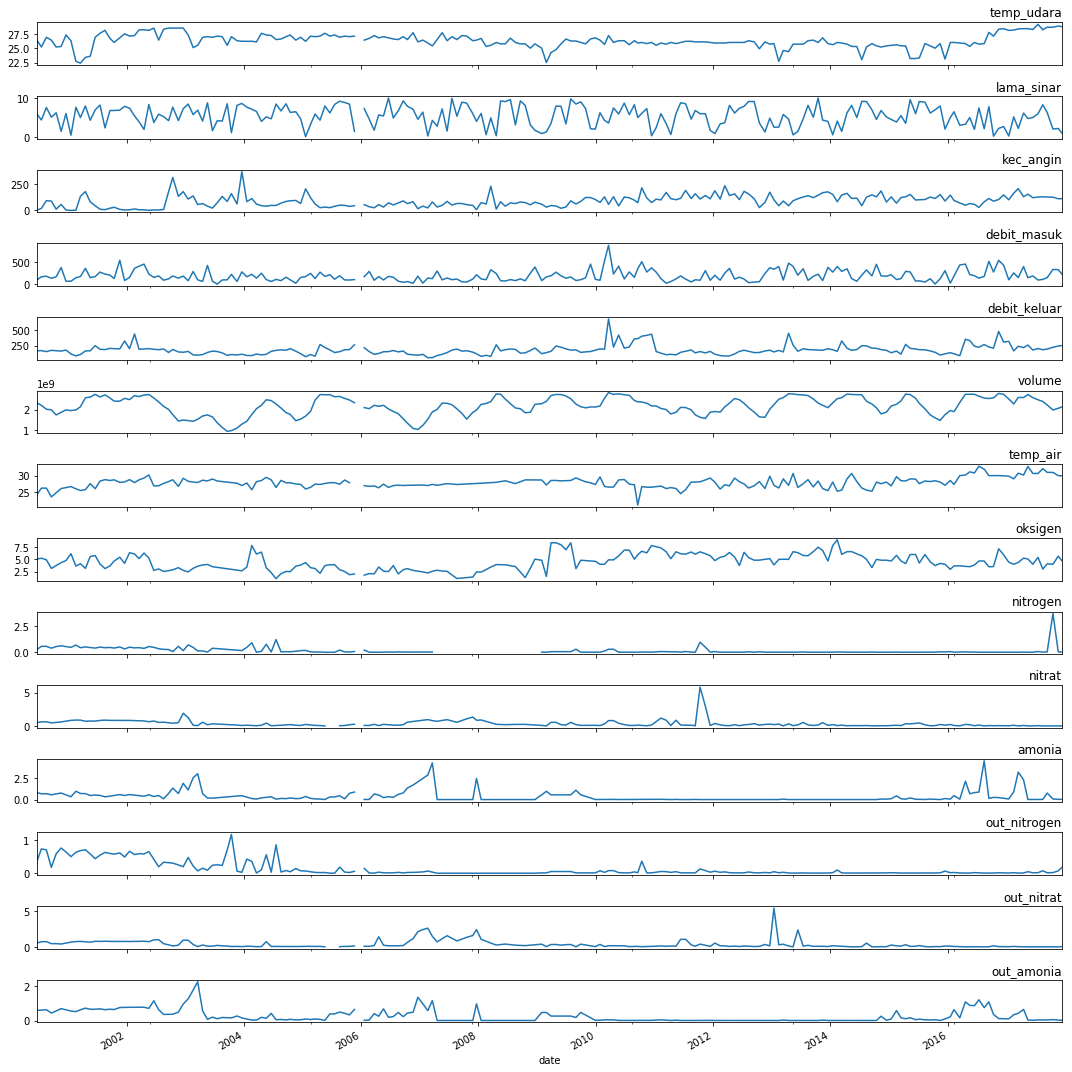

In [0]:
plot_dataset(dataset, ncols=1, nrows=14, figsize=(15, 15));

Dari grafik diatas terlihat ada data yang hilang.

## 1.3 Kehilangan Data

In [0]:
## Memperoleh informasi kehilangan data
loss_row = {}

print("Daftar kehilangan data:")
for column in dataset.columns:
    idx_null = dataset[dataset[column].isnull()].index.strftime('%Y/%m').values.tolist()
    loss_row[column] = idx_null
    print("KOLOM {}: {}".format(column, idx_null))

Daftar kehilangan data:
KOLOM temp_udara: ['2005/12']
KOLOM lama_sinar: ['2005/12']
KOLOM kec_angin: ['2005/12']
KOLOM debit_masuk: ['2005/12']
KOLOM debit_keluar: ['2005/12']
KOLOM volume: ['2005/12']
KOLOM temp_air: ['2005/11', '2005/12']
KOLOM oksigen: ['2005/12']
KOLOM nitrogen: ['2005/12', '2007/04', '2007/05', '2007/06', '2007/07', '2007/08', '2007/09', '2007/10', '2007/11', '2007/12', '2008/01', '2008/02', '2008/03', '2008/04', '2008/05', '2008/06', '2008/07', '2008/08', '2008/09', '2008/10', '2008/11', '2008/12']
KOLOM nitrat: ['2005/06', '2005/07', '2005/12']
KOLOM amonia: ['2005/12']
KOLOM out_nitrogen: ['2005/12']
KOLOM out_nitrat: ['2005/06', '2005/07', '2005/12']
KOLOM out_amonia: ['2005/12']




Dari proses diatas diperoleh informasi:
1. Pada bulan `2005/12` (Desember 2005), data tidak tersedia pada __seluruh kolom__.
2. Kolom `temp_air`, kehilangan data pada `2005/11` (November 2005).
3. Kolom `nitrogen`, kehilangan data pada dari `2007/04` (April 2007) sampai `2008/12` (Desember 2008).
4. Kolom `nitrat` dan `out_amonia`, kehilangan data pada `2005/06` (Juni 2005) dan `2005/07` (Juli 2005).`

### Mengisi Kehilangan data

__Diasumsikan__ bahwa data yang hilang dapat diisi dengan __metode interpolasi linear__. Dengan catatan metode tersebut digunakan dalam notebook ini untuk __pembelajaran__. Dimungkinkan untuk mengisi data hilang dengan teknik yang tersedia dalam bidang keahliannya. 

In [0]:
## Mengisi Data yang hilang dengan metode linear

new_dataset = dataset.interpolate(method='linear')

## 1.4 Eksplorasi dataset

In [0]:
# statistik deskriptif

new_dataset.describe()

,temp_udara,lama_sinar,kec_angin,debit_masuk,debit_keluar,volume,temp_air,oksigen,nitrogen,nitrat,amonia,out_nitrogen,out_nitrat,out_amonia
count,211.000000,211.000000,211.000000,211.000000,211.000000,2.110000e+02,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000
mean,26.297867,5.429739,89.090929,192.909614,181.526661,2.184541e+09,27.805279,4.398493,0.144310,0.354018,0.391544,0.124222,0.369451,0.258836
std,1.230595,2.653354,56.941944,129.691401,80.164627,4.316360e+08,1.592180,1.675356,0.322774,0.530511,0.709351,0.216860,0.591848,0.360054
min,22.400000,0.000000,0.400000,4.100000,57.942000,9.531267e+08,20.897500,1.053250,0.000000,0.004000,0.000000,0.000000,0.004667,0.000000
25%,25.750000,3.591667,47.350000,99.710000,135.915000,1.895588e+09,26.882917,3.125875,0.010000,0.070833,0.002958,0.006673,0.052589,0.002378
50%,26.200000,5.750000,83.300000,158.800000,170.140000,2.224052e+09,27.812500,4.166667,0.022000,0.187000,0.089250,0.019494,0.143512,0.066165
75%,27.000000,7.683333,125.400000,264.170000,201.090000,2.548267e+09,28.650000,5.683333,0.149181,0.540000,0.529875,0.085891,0.452636,0.448939
max,29.150000,10.083333,365.900000,879.730000,673.060000,2.822702e+09,32.916667,9.000000,3.700000,5.822500,4.583333,1.164635,5.460060,2.252332


### Visualisasi

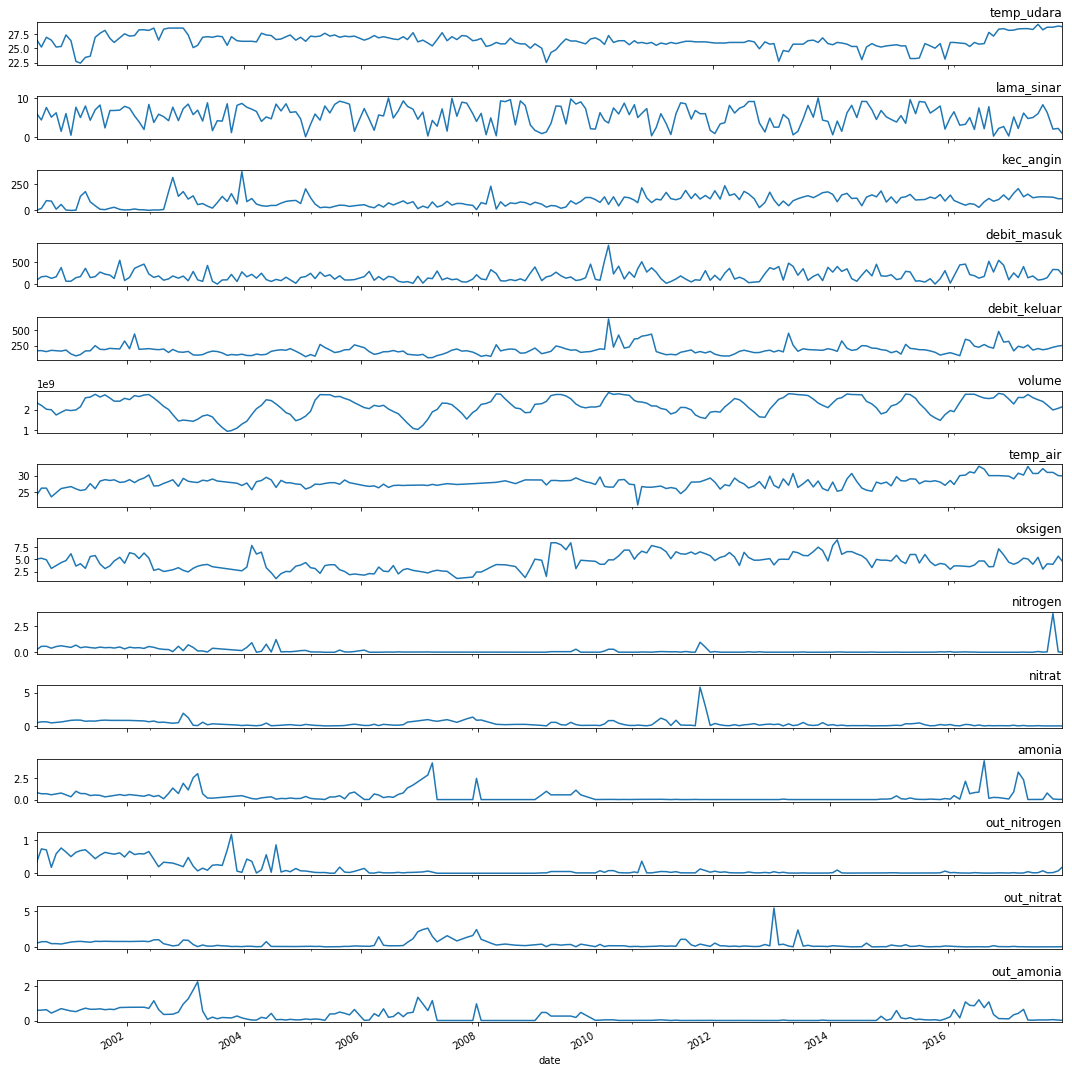

In [0]:
plot_dataset(new_dataset, ncols=1, nrows=14, figsize=(15, 15));

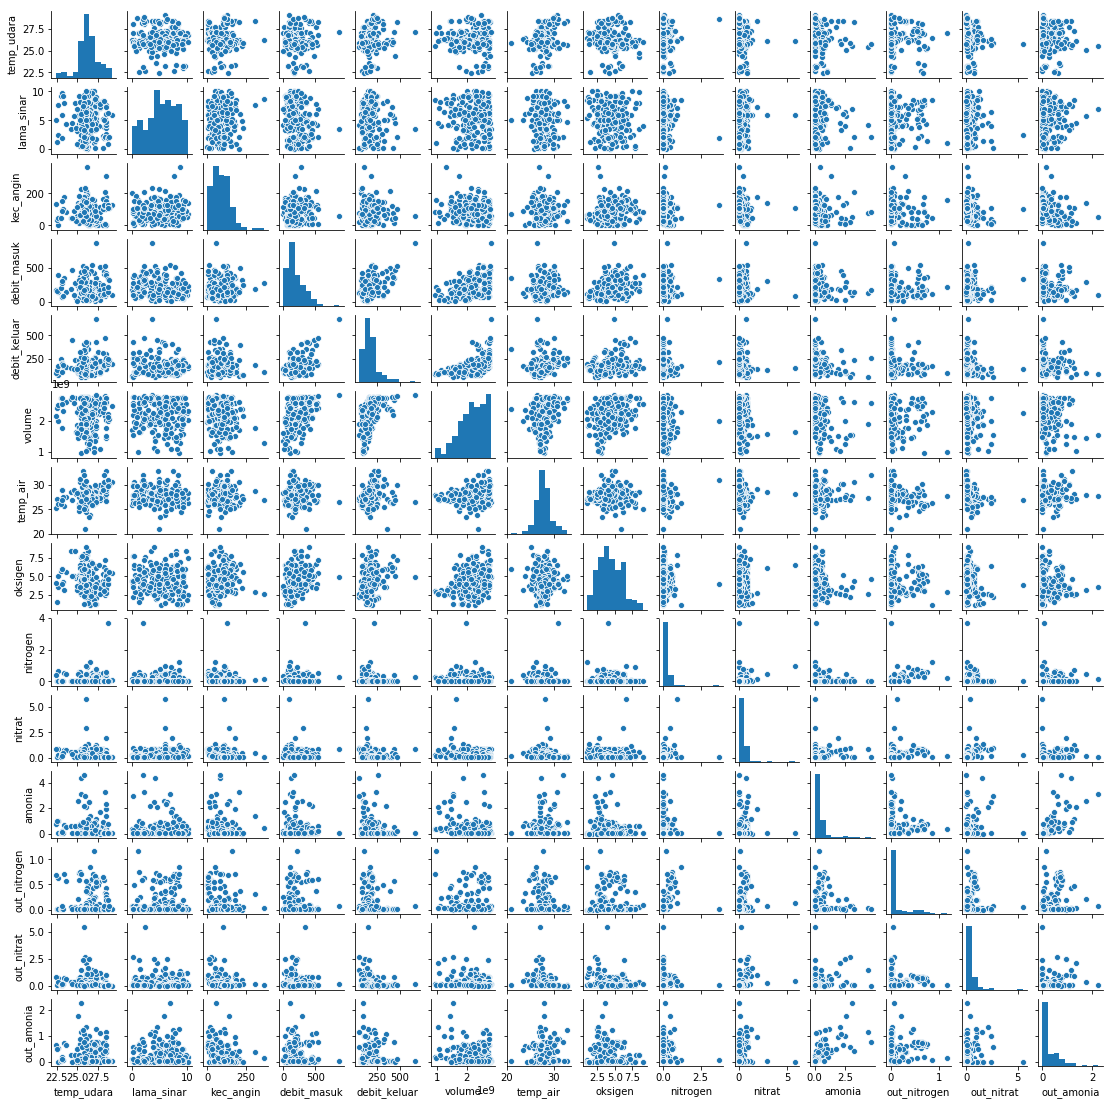

In [0]:
## Pairplot untuk melihat hubungan masing-masing kolom
import seaborn as sns

g = sns.pairplot(new_dataset)
g.fig.set_size_inches(15,15)

Dari visualisasi diatas diketahui bahwa terdapat kolom yang memiliki distribusi tidak normal, sehingga dalam _scaling_ digunakan `MinMaxScaler`.

# Tahap 2: _Data Preprocessing_

1. Membagi dataset menjadi _training set_ dan _test set_. 
2. _Scaling_ dengan `MinMaxScaler`.
3. Menambahkan kolom _timesteps_. 
4. Menampilkan hasil penambahan _timesteps_.
5. Mempersiapkan data _training_ dari _training set_ menjadi `X_train` dan `y_train`.

In [0]:
#### Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 2.1 _Training set_ dan _Test set_

Dari `new_dataset` yang telah diinterpolasi, akan dibagi menjadi dua bagian data yaitu training dan testing. 

- Training data merupakan data dari `2000/06` hingga `2014/12`
- Testing data merupakan data dari `2015/01` hingga `2017/12`

In [0]:
## Memisahkan dataset training dan test

training_dataset = new_dataset.loc[:"20141231", :]
test_dataset = new_dataset.loc["20150101":, :]

## Informasi training set dan testing set
print("Informasi training set: {} baris, {} kolom".format(
    training_dataset.shape[0], training_dataset.shape[1])
     )
print("Informasi testing set: {} baris, {} kolom".format(
    test_dataset.shape[0], test_dataset.shape[1])
     )


## Menampilkan training set
training_dataset.head()

Informasi training set: 175 baris, 14 kolom
Informasi testing set: 36 baris, 14 kolom


,temp_udara,lama_sinar,kec_angin,debit_masuk,debit_keluar,volume,temp_air,oksigen,nitrogen,nitrat,amonia,out_nitrogen,out_nitrat,out_amonia
date,,,,,,,,,,,,,,
2000-06-20,26.5,6.050000,1.4,91.35,168.32,2.334285e+09,23.937500,5.062500,0.235750,0.481875,0.825375,0.326915,0.524643,0.589523
2000-07-20,25.2,4.366667,19.6,168.52,170.14,2.203561e+09,26.125000,5.237500,0.570500,0.620375,0.689125,0.730400,0.727771,0.602750
2000-08-20,26.9,7.616667,92.5,181.32,154.55,2.019619e+09,26.125000,4.912500,0.570500,0.620375,0.688750,0.700556,0.742150,0.627844
2000-09-20,26.4,5.100000,88.4,133.62,175.08,1.991705e+09,23.416667,3.145833,0.390292,0.463708,0.569583,0.175556,0.457229,0.430150
2000-10-20,25.2,6.233333,12.1,168.56,168.64,1.742853e+09,24.708333,3.739583,0.547202,0.531271,0.671292,0.583651,0.461479,0.559891


Menyimpan nilai dalam `dataframe` dalam bentuk `numpy.array`.

In [0]:
array_train = training_dataset.values
array_train[:1, :]

array([[2.65000000e+01, 6.05000000e+00, 1.40000000e+00, 9.13500000e+01,
        1.68320000e+02, 2.33428460e+09, 2.39375000e+01, 5.06250000e+00,
        2.35750000e-01, 4.81875000e-01, 8.25375000e-01, 3.26914583e-01,
        5.24642857e-01, 5.89522917e-01]])

## 2.2 _Scaling_

Skala yang digunakan adalah `MinMaxScaler`.

In [0]:
#### Scaling dataset
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
array_train = sc.fit_transform(array_train)
array_train[:1, :]

array([[0.67213115, 0.6       , 0.00273598, 0.09964254, 0.17944199,
        0.738755  , 0.31118314, 0.50451442, 0.19395311, 0.08149884,
        0.19043453, 0.28070132, 0.09466023, 0.26173895]])

## 2.3 Kolom _Timesteps_

Setelah _scaling_, dataset dibuat kolom tambahan yang merepresentasikan data _timesteps_ sebelumnya. Untuk kasus ini dipilih timesteps sebanyak 2 bulan sebelumnya. Sehingga persamaan umumnya berupa:

$Output_t = f(Input_t, Input_{t-1}, Input_{t-2}, Output_{t-1}, Output_{t-2})$

Diketahui terdapat 14 kolom (termasuk output) dengan _timesteps_ 2, sehingga dimensi `array` menjadi $14 \times (2+1)=42$

In [0]:
## Menyertakan nilai n timesteps sebelumnya kedalam array
n_timesteps = 2
array_train_ts = multi_column_timesteps(array_train, n_timesteps=n_timesteps)
print("Dimensi array setelah diberi kolom timesteps: {}".format(array_train_ts.shape))

Dimensi array setelah diberi kolom timesteps: (173, 42)


## 2.4 Tabel _Training set_

Membuat tabel `pandas.DataFrame` untuk _training set_ yang telah diberi kolom _timesteps_.

In [0]:
## Menampilkan hasil pemberian kolom timestep dengan pandas.DataFrame
df_train_ts = {}
name_columns = new_dataset.columns.tolist()
new_name_columns = []

for col in name_columns:
    for i in range(n_timesteps+1):
        new_name = "{}_tmin{}".format(col, i)
        new_name_columns.append(new_name)

for i, col in enumerate(new_name_columns):
    df_train_ts[col] = array_train_ts[:, i]

df_train_ts = pd.DataFrame(df_train_ts)
df_train_ts.head()

,temp_udara_tmin0,temp_udara_tmin1,temp_udara_tmin2,lama_sinar_tmin0,lama_sinar_tmin1,lama_sinar_tmin2,kec_angin_tmin0,kec_angin_tmin1,kec_angin_tmin2,debit_masuk_tmin0,...,amonia_tmin2,out_nitrogen_tmin0,out_nitrogen_tmin1,out_nitrogen_tmin2,out_nitrat_tmin0,out_nitrat_tmin1,out_nitrat_tmin2,out_amonia_tmin0,out_amonia_tmin1,out_amonia_tmin2
0,0.737705,0.459016,0.672131,0.755372,0.433058,0.600000,0.251984,0.052531,0.002736,0.202391,...,0.190435,0.601524,0.627149,0.280701,0.134559,0.131922,0.094660,0.278753,0.267612,0.261739
1,0.655738,0.737705,0.459016,0.505785,0.755372,0.433058,0.240766,0.251984,0.052531,0.147916,...,0.158998,0.150739,0.601524,0.627149,0.082294,0.134559,0.131922,0.190980,0.278753,0.267612
2,0.459016,0.655738,0.737705,0.618182,0.505785,0.755372,0.032011,0.240766,0.251984,0.187819,...,0.158912,0.501145,0.150739,0.601524,0.083074,0.082294,0.134559,0.248583,0.190980,0.278753
3,0.475410,0.459016,0.655738,0.140496,0.618182,0.505785,0.153762,0.032011,0.240766,0.425397,...,0.131417,0.650329,0.501145,0.150739,0.072670,0.083074,0.082294,0.306186,0.248583,0.190980
4,0.803279,0.475410,0.459016,0.598347,0.140496,0.618182,0.010397,0.153762,0.032011,0.072725,...,0.154884,0.547268,0.650329,0.501145,0.096521,0.072670,0.083074,0.275712,0.306186,0.248583


## 2.5 `X_train` dan `y_train`

Berdasarkan persamaan sebelumnya, kolom _output_ pada waktu $t$ harus dipisahkan sebagai label _training_-nya. Dan karena dalam kasus ini fokus pada _single-output_, maka kolom _output_ yang digunakan sebagai _target_ hanya `out_amonia_tmin0`.

In [0]:
## Pembagian X_train dan y_train untuk 
## Kasus Single-Output Regression Neural Network

target_col = ["out_amonia_tmin0"]
drop_col = ["out_nitrogen_tmin0", "out_nitrat_tmin0", "out_amonia_tmin0"]
df_X_train = df_train_ts.drop(drop_col, axis=1)
df_y_train = df_train_ts[target_col]
X_train = df_X_train.values
y_train = df_y_train.values.flatten()
print(f"Dimensi X_train = {X_train.shape}")
print(f"Dimensi y_train = {y_train.shape}")

Dimensi X_train = (173, 39)
Dimensi y_train = (173,)


Catatan: Terdapat __39 _features___ dengan __1 _target___. 

# Tahap 3: _Building Neural Networks_

1. Fungsi `build_model`.
2. Penggunaan `GridSearchCV`.
3. Melalukan proses `fit` terhadap `X_train, y_train`

## 3.1 Fungsi `build_model`

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

def build_model(optimizer='adam', activation='sigmoid', first_layer=10, 
                hidden_layers=[30], p=0, message=True):
    global idx
    model = Sequential()
    model.add(Dense(first_layer, activation=activation, input_dim=39))
    model.add(Dropout(p))
    
    if hidden_layers:
        for x in hidden_layers:
            model.add(Dense(x, activation=activation))
            if x == hidden_layers[-1]:
                model.add(Dropout(p/2))
            else:
                model.add(Dropout(p))
    
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error', 
                  metrics=['mse', 'mae'])
    
    if message and ('idx' in globals()):
        print(f"{idx}>", end="")
        idx -= 1
        if (idx % 10) == 0:
            print()
    
    return model

model = KerasRegressor(build_fn=build_model, verbose=0)

Using TensorFlow backend.


## 3.2 Parameter `GridSearchCV`

In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(epochs=[100,150,200],
                  batch_size=[5,10,20],
                  first_layer=[10, 20, 30],
                  hidden_layers=[[10], [20], [30]],
                  activation=['sigmoid', 'relu'],
                  optimizer=['adam'],
                 )

# Ignore K-Fold Cross Validation
# cv = [(slice(None), slice(None))]
cv = 3

grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid,
                           cv=cv,
                           return_train_score=True,
                           verbose=1,
                           scoring='neg_mean_squared_error',
                          )



## 3.3 `Fit`

### 3.3.1 `Fitting`

In [0]:
# # idx
# search_steps = 1
# for key, val in param_grid.items():
#     search_steps *= len(val)
# idx = search_steps*cv if (type(cv) is int) else search_steps

# # Fitting
# print(mylog.add_savepoint("START FITTING", 'fit'))

# grid_search = grid_search.fit(X_train, y_train, verbose=0, validation_split=0.2)

# print(mylog.add_savepoint("END FITTING", 'fit'))
# print(mylog.add_duration('fit'))

### 3.3.2 _Saving_

In [0]:
# # Save model in JSON
# fmodel_json = final_model.to_json()
# fmodel_j_path = drop_path + '/{}.json'.format(project_title)
# with open(fmodel_j_path, 'w') as json_file:
#     json_file.write(fmodel_json)
    
# # Save Wrights of model
# fmodel_w_path = drop_path + '/{}_weights.h5'.format(project_title)
# final_model.save_weights(fmodel_w_path)

In [0]:
# # Menyimpan object keras di final_model
# final_model = grid_search.best_estimator_.model

# ## Simpan model dan grid_search object
# save_model_path = drop_path + '/' + project_title + '.h5'
# final_model.save(save_model_path)
# mylog.add(f'Model disimpan di {save_model_path}')

# ## Simpan hasil GridSearch
# save_grid_path = drop_path + '/{}.csv'.format(project_title)
# df_cv = pd.DataFrame(grid_search.cv_results_)
# df_cv.to_csv(save_grid_path)
# mylog.add(f'Tabel GridSearch disimpan di {save_grid_path}')
# df_cv.head()

### 3.3.3 Loading (Jika sudah disimpan Model dan Hasil _grid search_)

In [0]:
load_model_path = drop_path + '/20190512_2037_kualitas_air_ann_so.h5'
load_cvgrid_path = drop_path + '/20190512_2037_kualitas_air_ann_so.csv'

from keras.models import load_model
final_model = load_model(load_model_path)

df_cv = pd.read_csv(load_cvgrid_path, index_col=[0])
df_cv.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_batch_size,param_epochs,param_first_layer,param_hidden_layers,param_optimizer,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,2.558138,0.176801,0.040308,0.016821,sigmoid,5,100,10,[10],adam,...,-0.018113,-0.008957,-0.017676,0.006876,35,-0.005007,-0.006401,-0.006864,-0.006091,0.000790
1,2.565923,0.084442,0.102884,0.017689,sigmoid,5,100,10,[20],adam,...,-0.018643,-0.003479,-0.014959,0.008205,10,-0.003048,-0.005881,-0.008486,-0.005805,0.002221
2,3.004355,0.079835,0.163490,0.018423,sigmoid,5,100,10,[30],adam,...,-0.015164,-0.007385,-0.017223,0.008911,29,-0.005620,-0.006043,-0.009286,-0.006983,0.001638
3,3.261551,0.078320,0.232554,0.018282,sigmoid,5,100,20,[10],adam,...,-0.014912,-0.004461,-0.014403,0.007836,4,-0.003511,-0.006519,-0.009789,-0.006606,0.002564
4,3.658714,0.097554,0.305864,0.026602,sigmoid,5,100,20,[20],adam,...,-0.013765,-0.007933,-0.015509,0.006945,14,-0.003910,-0.006562,-0.007323,-0.005932,0.001463


# Tahap 4: _Evaluate Model_

1. _Data preprocessing_ pada _test set_.
2. Memprediksi nilai dengan model yang terbaik hasil _Grid Search_. 
3. Mengembalikan ke skala aslinya. 
4. Evaluasi Model pada _test set_.
5. Nilai beda prediksi dan observasi.

## 4.1 _Data preprocessing_ pada _test set_

In [0]:
## Menampilkan test dataset

test_dataset.head()

,temp_udara,lama_sinar,kec_angin,debit_masuk,debit_keluar,volume,temp_air,oksigen,nitrogen,nitrat,amonia,out_nitrogen,out_nitrat,out_amonia
date,,,,,,,,,,,,,,
2015-01-14,25.5,4.500000,127.68,214.64,137.25,2.174360e+09,26.833333,4.666667,0.0125,0.0675,0.100000,0.014000,0.261190,0.088036
2015-02-16,25.6,3.833333,68.64,105.93,162.18,2.256351e+09,29.666667,5.833333,0.0175,0.1075,0.441667,0.012631,0.152798,0.578571
2015-03-16,25.4,5.500000,121.68,127.03,114.78,2.422154e+09,28.416667,4.666667,0.0040,0.0600,0.100000,0.005214,0.109405,0.153452
2015-04-14,25.4,3.500000,128.88,291.23,269.31,2.751982e+09,28.333333,4.150000,0.0080,0.3350,0.050000,0.005286,0.308036,0.102560
2015-05-12,23.2,9.666667,151.20,277.62,205.84,2.724559e+09,29.000000,6.000000,0.0055,0.3100,0.191667,0.004143,0.069940,0.165476


In [0]:
## pandas.DataFrame ke numpy.array
array_test = test_dataset.values
array_test = sc.transform(array_test)
array_test_ts = multi_column_timesteps(array_test, n_timesteps=n_timesteps)

## menampilkan array_test_ts dalam bentuk pandas.DataFrame
df_test = {}

for i, col in enumerate(new_name_columns):
    df_test[col] = array_test_ts[:, i]

df_test = pd.DataFrame(df_test)
df_test.head()

,temp_udara_tmin0,temp_udara_tmin1,temp_udara_tmin2,lama_sinar_tmin0,lama_sinar_tmin1,lama_sinar_tmin2,kec_angin_tmin0,kec_angin_tmin1,kec_angin_tmin2,debit_masuk_tmin0,...,amonia_tmin2,out_nitrogen_tmin0,out_nitrogen_tmin1,out_nitrogen_tmin2,out_nitrat_tmin0,out_nitrat_tmin1,out_nitrat_tmin2,out_amonia_tmin0,out_amonia_tmin1,out_amonia_tmin2
0,0.491803,0.524590,0.508197,0.545455,0.380165,0.446281,0.331819,0.186703,0.348235,0.140390,...,0.023072,0.004477,0.010845,0.012021,0.018490,0.026450,0.046333,0.068130,0.256877,0.039086
1,0.491803,0.491803,0.524590,0.347107,0.545455,0.380165,0.351518,0.331819,0.186703,0.327912,...,0.101903,0.004539,0.004477,0.010845,0.054926,0.018490,0.026450,0.045535,0.068130,0.256877
2,0.131148,0.491803,0.491803,0.958678,0.347107,0.545455,0.412585,0.351518,0.331819,0.312369,...,0.023072,0.003557,0.004539,0.004477,0.011251,0.054926,0.018490,0.073469,0.045535,0.068130
3,0.131148,0.131148,0.491803,0.595041,0.958678,0.347107,0.268126,0.412585,0.351518,0.076288,...,0.011536,0.004079,0.003557,0.004539,0.014790,0.011251,0.054926,0.020981,0.073469,0.045535
4,0.147541,0.131148,0.131148,0.909091,0.595041,0.958678,0.274692,0.268126,0.412585,0.083951,...,0.044222,0.003772,0.004079,0.003557,0.032990,0.014790,0.011251,0.035138,0.020981,0.073469


In [0]:
## Pembagian X_test dan y_test untuk 
## Kasus Single-Output Regression Neural Network
## Meninjau output_amonia 

df_X_test = df_test.drop(drop_col, axis=1)
df_y_test = df_test[target_col]
X_test = df_X_test.values
y_test = df_y_test.values.flatten()
print(f"Dimensi X_test = {X_test.shape}")
print(f"Dimensi y_test = {y_test.shape}")

Dimensi X_test = (34, 39)
Dimensi y_test = (34,)


## 4.2 Prediksi model dari parameter terbaik hasil _Grid Search_

In [0]:
# Prediksi
predict = final_model.predict(X_test)
truth = y_test

digunakan istilah _predict_ sebagai nilai prediksi dari `final_model`, dan _truth_ sebagai nilai observasi di stasiun B.

## 4.3 Mengembalikan ke skala aslinya

In [0]:
# Transfer attribute from MinMax Scaler (specific for last column (output) only)

sc_test = MinMaxScaler()
sc_test.min_, sc_test.scale_, sc_test.data_min_, sc_test.data_max_ = sc.min_[-1], sc.scale_[-1], sc.data_min_[-1], sc.data_max_[-1]

# Mengembalikan ke skala original
predict_real = sc_test.inverse_transform(predict.reshape(-1,1))
truth_real = sc_test.inverse_transform(truth.reshape(-1,1))

Nilai `-1` menunjukkan posisi kolom `out_amonia` saat melakukan proses `fit` pada _object_ `sc` (`MinMaxScaler`). 

In [0]:
# Dalam bentuk pandas.DataFrame
diff_table = pd.DataFrame(dict(predict=predict_real.flatten(),
                               truth=truth_real.flatten(),
                              ))
diff_table['diff'] = (diff_table.predict - diff_table.truth).abs()
diff_table.T

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
predict,0.145506,0.03418,0.121588,0.172865,0.001295,-0.102068,-0.070623,-0.017800,-0.135017,0.070638,...,1.117018,0.976593,0.281038,0.079371,0.097984,0.074026,0.366595,0.239648,0.222569,-0.022811
truth,0.153452,0.10256,0.165476,0.047256,0.079143,0.041720,0.029899,0.046929,0.001708,0.091464,...,0.414250,0.647083,0.028232,0.017208,0.033149,0.034988,0.032571,0.052371,0.025548,0.013155
diff,0.007947,0.06838,0.043888,0.125609,0.077848,0.143789,0.100522,0.064728,0.136726,0.020827,...,0.702768,0.329510,0.252806,0.062163,0.064835,0.039038,0.334024,0.187277,0.197021,0.035966


## 4.4 Evaluasi Model _test set_

### 4.4.1 Metrik

In [0]:
metrics_train = final_model.evaluate(X_train, y_train, verbose=0)
metrics_test = final_model.evaluate(X_test, y_test, verbose=0)

for i, metrics in enumerate(final_model.metrics_names):
    print(f"Metrics: {metrics}")
    print(f"Train: {metrics_train[i]:.5f}")
    print(f"Test: {metrics_test[i]:.5f}")
    print()

Metrics: loss
Train: 0.00428
Test: 0.02021

Metrics: mean_squared_error
Train: 0.00428
Test: 0.02021

Metrics: mean_absolute_error
Train: 0.04264
Test: 0.09679



Fungsi `loss` yang digunakan saat training adalah `mean_squared error`. Dari informasi diatas diketahui bahwa nilai _MSE_ dan _MAE_ pada saat _training_ hampir mendekati 0 dengan nilai $0.00428$ dan $0.04264$. Sedangkan saat menggunakan _test set_ diperoleh $0.02021$ dan $0.09679$. Perlu dicatat bahwa nilai tersebut berdasarkan nilai yang telah ditransformasi dengan metode `MinMaxScaler`. 

In [0]:
## menghitung MSE dan MAE test set dengan skala original
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_real = mean_squared_error(truth_real, predict_real)
mae_real = mean_absolute_error(truth_real, predict_real)

print(f"MSE (Original Scale): {mse_real:.4f}")
print(f"MAE (Original Scale): {mae_real:.4f}")

MSE (Original Scale): 0.1025
MAE (Original Scale): 0.2180


Diperoleh hasil _MSE_ dan _MAE_ perbandingan nilai prediksi dan observasi sebesar $0.1025$ dan $0.2180$.

### 4.4.2 Visualiasi

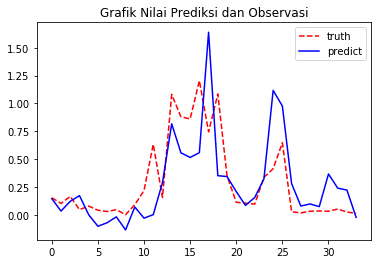

In [0]:
#### PLOT OUT_AMONIA PREDICTION AND TRUTH (OBSERVED VALUE)
plt.plot(truth_real, 'r--', label='truth')
plt.plot(predict_real, 'b', label='predict')
plt.title('Grafik Nilai Prediksi dan Observasi')
plt.legend()
plt.show()

Dari grafik diatas diketahui bahwa `final_model` mampu mengikuti fluktuasi data observasi.

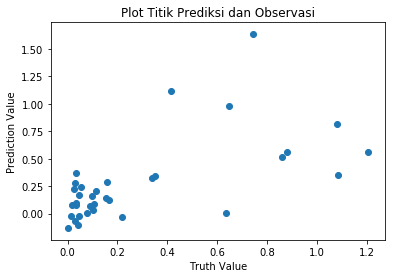

In [0]:
# PLOT TRUTH vs. PREDICT

plt.scatter(y=predict_real, x=truth_real)
plt.xlabel('Truth Value')
plt.ylabel('Prediction Value')
plt.title('Plot Titik Prediksi dan Observasi')
plt.show()

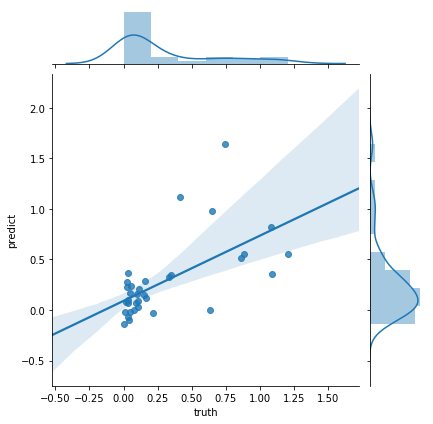

In [0]:
# Menggunakan seaborn

sns.jointplot(x='truth', y='predict', kind='reg', data=diff_table);

Dari dua grafik diatas terlihat bahwa terdapat hasil prediksi yang negatif meski pada kejadian nyata bahwa nilai negatif tidak mungkin untuk kualitas air.

## 4.5 Nilai beda prediksi dan observasi

### 4.5.1 Metrik

In [0]:
# statistik deskriptif nilai Beda (Residu)

diff_table['diff'].describe()

count    34.000000
mean      0.218002
std       0.238075
min       0.006341
25%       0.059962
50%       0.129470
75%       0.308631
max       0.894172
Name: diff, dtype: float64

Dari statistik deskriptif diatas diketahui bahwa nilai median (50%) sebesar $0.129470$. Dengan rata-rata nilai beda sebesar $0.218002$. Perlu diperhatikan juga nilai standar deviasi $0.238075$. Ini kembali lagi ke nilai toleransi/ketelitian pada parameter tersebut, apakah rata-rata $0.2$ termasuk signifikan atau tidak. 

### 4.5.2 Visualisasi

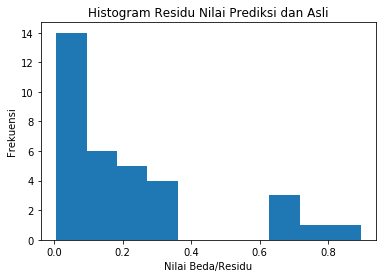

In [0]:
# plot histogram

diff = diff_table['diff'].values
plt.hist(diff)
plt.xlabel('Nilai Beda/Residu')
plt.ylabel('Frekuensi')
plt.title('Histogram Residu Nilai Prediksi dan Asli')
plt.show()

# Tahap 5: _Conclusion and Interpretation_

1. Interpretasi model ANN
2. Evaluasi hasil GridSearch
3. Ringkasan
4. Saran dan langkah selanjutnya

## 5.1 Interpretasi Model _Neural Networks_

In [0]:
# menghilangkan [] pada hidden layers di df_cv
df_cv['param_hidden_layers'] = df_cv['param_hidden_layers'].apply(lambda x: (str(x[1:-1])) if str(x[0]) == '[' else x)

# memilih kolom yang akan digunakan untuk interpretasi
col_grid = ['param_activation', 'param_batch_size', 'param_epochs', 
            'param_first_layer', 'param_hidden_layers', 'param_optimizer',
            'mean_test_score', 'rank_test_score'
           ]
df_grid = df_cv[col_grid]
print(df_grid.shape)
df_grid.head()

(162, 8)


,param_activation,param_batch_size,param_epochs,param_first_layer,param_hidden_layers,param_optimizer,mean_test_score,rank_test_score
0,sigmoid,5,100,10,10,adam,-0.017676,35
1,sigmoid,5,100,10,20,adam,-0.014959,10
2,sigmoid,5,100,10,30,adam,-0.017223,29
3,sigmoid,5,100,20,10,adam,-0.014403,4
4,sigmoid,5,100,20,20,adam,-0.015509,14


In [0]:
# mengurutkan berdasarkan mean_test_score / rank_test_score
df_grid_sorted = df_grid.sort_values('rank_test_score')
df_grid_sorted.head()

,param_activation,param_batch_size,param_epochs,param_first_layer,param_hidden_layers,param_optimizer,mean_test_score,rank_test_score
77,sigmoid,20,200,20,30,adam,-0.013254,1
69,sigmoid,20,150,30,10,adam,-0.013915,2
33,sigmoid,10,100,30,10,adam,-0.013985,3
3,sigmoid,5,100,20,10,adam,-0.014403,4
65,sigmoid,20,150,10,30,adam,-0.014514,5


Maka, berdasarkan `GridSearchCV` diperoleh model terbaik dengan parameter:
- activation: `sigmoid`
- batch_size: `20`
- epochs: `200`
- first_layer: `20`
- hidden_layer: `30`
- optimizer: `adam`


In [0]:
df_grid_sorted.tail()

,param_activation,param_batch_size,param_epochs,param_first_layer,param_hidden_layers,param_optimizer,mean_test_score,rank_test_score
129,relu,10,200,20,10,adam,-0.049281,158
98,relu,5,150,30,30,adam,-0.051000,159
134,relu,10,200,30,30,adam,-0.052442,160
83,relu,5,100,10,30,adam,-0.054173,161
130,relu,10,200,20,20,adam,-0.078473,162


Dengan model terburuk adalah:
- activation: `relu`
- batch_size: `10`
- epochs: `200`
- first_layer: `20`
- hidden_layer: `20`
- optimizer: `adam`


## 5.2 Evaluasi hasil `GridSearchCV`

In [0]:
# evaluasi 50 hasil terbaik
df_grid_top = df_grid_sorted.iloc[:50,:].copy()

# menghitung nilai unik tiap kolom
for col in df_grid_top.columns[:-2]:
    print(df_grid_top[col].value_counts())

sigmoid    46
relu        4
Name: param_activation, dtype: int64
20    20
10    18
5     12
Name: param_batch_size, dtype: int64
100    22
150    16
200    12
Name: param_epochs, dtype: int64
30    19
10    18
20    13
Name: param_first_layer, dtype: int64
20    18
10    16
30    16
Name: param_hidden_layers, dtype: int64
adam    50
Name: param_optimizer, dtype: int64


Dari informasi diatas diketahui bahwa aktivasi `sigmoid` memiliki performa lebih baik dibandingkan `relu`. Selain parameter aktivasi, tidak ada perbedaan signifikan dengan pemilihan parameter model.

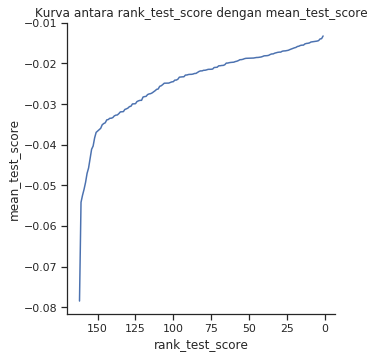

In [0]:
# Grafik antara rank_test_score dan mean_test_score
sns.set(style='ticks')
relplot = sns.relplot(x='rank_test_score', y='mean_test_score', data=df_grid, kind='line')
plt.gca().set_title("Kurva antara rank_test_score dengan mean_test_score")
plt.gca().invert_xaxis()

Dari kurva diatas bisa dilihat nilai beda antara _rank_test_score_ mendekati $0.01$ dimulai dari urutan ke 75. 

## 5.3 Ringkasan

1. Model terbaik diperoleh dengan parameter:
    - activation: `sigmoid`
    - batch_size: `20`
    - epochs: `200`
    - first_layer: `20`
    - hidden_layer: `30`
    - optimizer: `adam`
2. Dalam evaluasi model dengan _test set_ diperoleh informasi:
    - MSE dan MAE  sebesar $0.1025$ dan $0.2180$ (dalam skala original).
    - Nilai rata-rata nilai beda (`diff`) sebesar $0.218002$ (MAE), dengan standar deviasi sebesar $0.238075$.

## 5.4 Saran dan Langkah Selanjutnya

- Diketahui bahwa terdapat nilai negatif pada prediksi, sehingga untuk model selanjutnya lebih baik bahwa pada _output layer_ menggunakan aktivasi `relu` sehingga tidak mengeluarkan hasil negatif. 
- Mengurangi vektor _input_, dengan menentukan kolom yang dirasa penting saja untuk pemberian kolom tambahan _timesteps_. 
- Mengevaluasi pengisian data kosong, karena pendekatan _linear_ belum tentu tepat.
- Memeriksa kondisi _outlier_. Dipilihnya _output_ amonia karena pada nitrogen dan nitrat terdapat kondisi _outlier_. 

# Laporan melalui email

In [0]:
# # RESULTS
# mylog.add("Best Parameters: {}".format(grid_search.best_params_))

# # REPORTING TO EMAIL
# msg = []
# msg.append("REPORT FROM GOOGLE COLAB: {}".format(project_title))
# msg.append("\nINFO LOGGING")
# msg.append(mylog.summary())
# msg.append("END OF REPORT")

# print(uma.send_email("\n".join(msg), add_subject=project_title))

#### Changelog

##### 2019-06-22
- Copyright notice. License.
- Publish to hidrokit-nb. 

##### 2019-04-14
- Initial release


##### Copyright &copy; 2019 Taruma Sakti Megariansyah

Source code in this notebook is licensed under a [MIT License](https://opensource.org/licenses/MIT). Data in this notebook is licensed under a [Creative Common Attribution 4.0 International](https://choosealicense.com/licenses/cc-by-4.0/). 